# Happiness Score

## Explore the data

### Import libaries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [5]:
happy_data = pd.read_csv(r"C:\Users\hassa\Downloads\2018.csv")
happy_data.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.632,1.305,1.592,0.874,0.681,0.202,0.393
1,2,Norway,7.594,1.456,1.582,0.861,0.686,0.286,0.340
2,3,Denmark,7.555,1.351,1.590,0.868,0.683,0.284,0.408
3,4,Iceland,7.495,1.343,1.644,0.914,0.677,0.353,0.138
4,5,Switzerland,7.487,1.420,1.549,0.927,0.660,0.256,0.357


In [6]:
happy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB


In [7]:
happy_data = happy_data.rename(columns={'GDP per capita': 'GDP_per_capita', 
                                        'Social support': 'Social_support', 
                                        'Healthy life expectancy': 'Healthy_life_exp', 
                                        'Freedom to make life choices': 'Freedom_of_life_choices', 
                                        'Perceptions of corruption': 'Perceptions_of_corruption'})

## Findind the best model

### Base model

In [10]:
# Define the formula with predictors
formula = 'Score ~ GDP_per_capita + Social_support + Healthy_life_exp + Freedom_of_life_choices + Perceptions_of_corruption'

# Fit the model using OLS
model = smf.ols(formula, happy_data)
result = model.fit()

# Display the model summary
print(result.summary())

# Generate predictions
predictions = result.predict()

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     111.2
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           1.25e-48
Time:                        19:00:13   Log-Likelihood:                -117.66
No. Observations:                 156   AIC:                             247.3
Df Residuals:                     150   BIC:                             265.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### Correlation

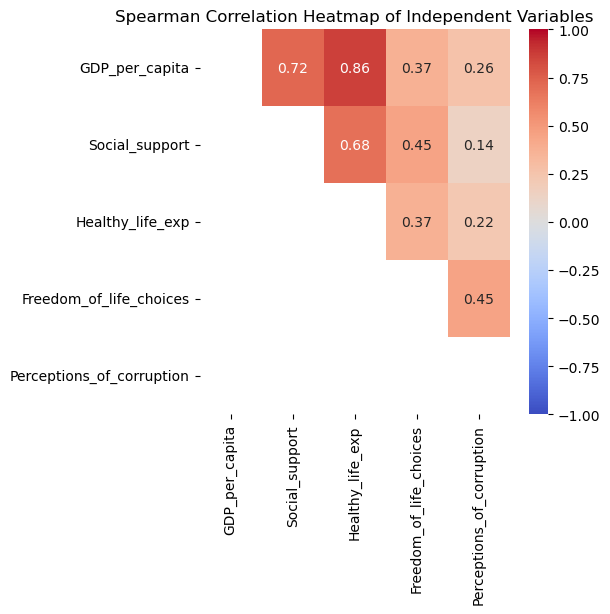

In [12]:

# Select only independent variables for correlation analysis
happy_data_ind_var = happy_data[['GDP_per_capita', 'Social_support', 'Healthy_life_exp', 
                                 'Freedom_of_life_choices', 'Perceptions_of_corruption']]

# Compute the Spearman correlation matrix
corr_matrix = happy_data_ind_var.corr(method='spearman')

# Create a mask for the lower triangle
mask = np.tril(corr_matrix)

# Plot the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(round(corr_matrix, 2), mask=mask, vmax=1, vmin=-1, center=0, 
            cmap='coolwarm', annot=True, annot_kws={"size": 10})
plt.title('Spearman Correlation Heatmap of Independent Variables')
plt.show()


array([[<Axes: title={'center': 'GDP_per_capita'}>,
        <Axes: title={'center': 'Social_support'}>],
       [<Axes: title={'center': 'Healthy_life_exp'}>,
        <Axes: title={'center': 'Freedom_of_life_choices'}>],
       [<Axes: title={'center': 'Perceptions_of_corruption'}>, <Axes: >]],
      dtype=object)

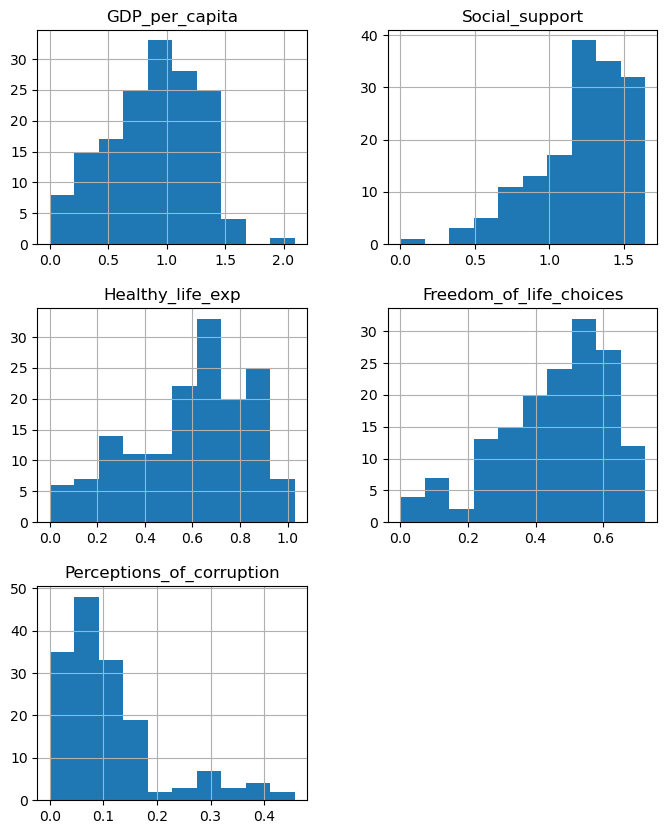

In [13]:
happy_data_ind_var.hist(figsize=(8,10))

In [15]:

# Independent variables (predictors)
happy_data_ind_var = happy_data[['GDP_per_capita', 'Social_support', 'Healthy_life_exp', 
                                 'Freedom_of_life_choices', 'Perceptions_of_corruption']]

# Dependent variable (target)
happy_data_dep_var = happy_data['Score']

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    happy_data_ind_var, happy_data_dep_var, test_size=0.25, random_state=42
)

# Combine predictors and target for train and test datasets
happy_data_train = pd.concat([x_train, y_train], axis=1)
happy_data_test = pd.concat([x_test, y_test], axis=1)


### Model Reduction

In [19]:
def backward_elimination(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    initial_features.remove(target)  # Exclude target variable from the feature set
    
    while True:
        formula = target + " ~ " + ' + '.join(initial_features)
        model = smf.ols(formula, data).fit()

        # Check p-values of each predictor (excluding the intercept)
        p_values = model.pvalues[1:]
        max_p_value = p_values.max()

        # If the max p-value is greater than significance level, remove the corresponding predictor
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()  # Feature with the highest p-value
            initial_features.remove(excluded_feature)  # Remove the feature
            print(f"Excluding feature: {excluded_feature}, Max p-value: {max_p_value}")
        else:
            break  # Stop when all features have p-values below the significance level

    return initial_features

# Perform backward elimination to reduce the model
reduced_features = backward_elimination(happy_data_train, 'Score')

# Display reduced formula
reduced_formula = 'Score ~ ' + ' + '.join(reduced_features)
print("Reduced Formula: ", reduced_formula)

# Fit the reduced model
reduced_model = smf.ols(reduced_formula, happy_data_train).fit()

# Display the reduced model summary
print(reduced_model.summary())

# Generate predictions with the reduced model
predictions_reduced = reduced_model.predict()

Excluding feature: Perceptions_of_corruption, Max p-value: 0.290403242801659
Reduced Formula:  Score ~ GDP_per_capita + Social_support + Healthy_life_exp + Freedom_of_life_choices
                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     113.6
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           1.72e-38
Time:                        19:11:01   Log-Likelihood:                -87.684
No. Observations:                 117   AIC:                             185.4
Df Residuals:                     112   BIC:                             199.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              

### Residuals

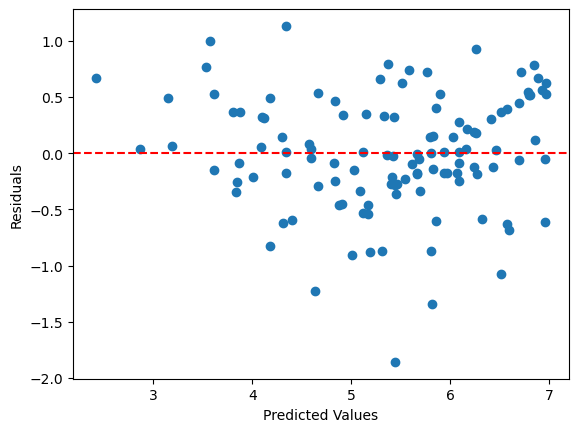

In [20]:
residuals = reduced_model.resid
plt.scatter(predictions_reduced, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


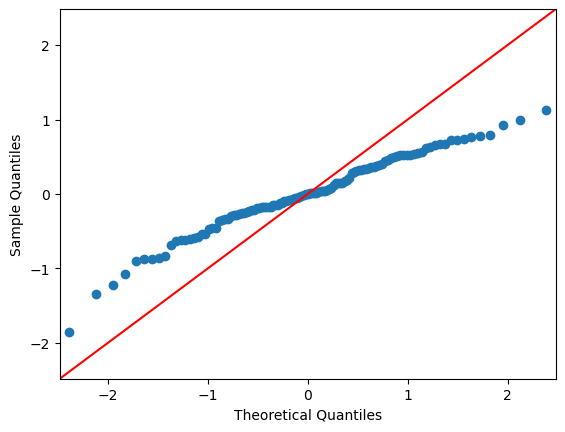

In [21]:
sm.qqplot(residuals, line ='45')
plt.show()


In [23]:
predictions_test = reduced_model.predict(happy_data_test)

### Evaluation metrics

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, predictions_test)
mse = mean_squared_error(y_test, predictions_test)
rmse = mean_squared_error(y_test, predictions_test, squared=False)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")


MAE: 0.44916576921710943, MSE: 0.30221412211401205, RMSE: 0.5497400495816291
